## ECG Preprocessing Pipeline

### 1. Load Clean Dataset

In [1]:
!pip install scikit-learn==1.5.2 imbalanced-learn==0.12.3
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.combine import SMOTETomek
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

file_path = 'missingvaluesdone.csv'
df = pd.read_csv(file_path)
print('Initial shape:', df.shape)
df.head()


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Initial shape: (13328, 137)


,HR_mean,HR_std,PR_mean,PR_std,QRSd_mean,QRSd_std,QT_mean,QT_std,JTc_mean,JTc_std,...,st80_aVF_std,vat_aVF_mean,vat_aVF_std,ramp_aVF_mean,ramp_aVF_std,tamp_aVF_mean,tamp_aVF_std,age,sex,condition
0,62.419378,7.254019,178.625000,25.377909,108.146341,81.480228,389.678571,109.563114,285.452979,81.261413,...,0.018684,55.636364,12.611683,0.429000,0.078032,0.133300,0.098816,56.0,1.0,Normal
1,46.043361,6.425092,186.303797,24.492989,95.063291,21.392152,380.253165,40.499911,248.865670,43.646579,...,0.012294,47.142857,16.077195,1.391143,0.071460,0.337714,0.071161,19.0,0.0,Normal
2,74.587370,3.379025,179.134752,23.376796,104.408451,19.260865,372.253521,72.162881,298.168406,75.502867,...,0.030279,67.333333,14.253123,1.370167,0.151857,0.417083,0.161089,24.0,0.0,Normal
3,64.641225,8.128676,182.868852,20.198990,107.377049,51.313383,383.150000,67.983024,289.990565,74.022704,...,0.012784,38.600000,11.663809,1.203400,0.058835,0.214900,0.044089,19.0,1.0,Normal
4,79.109622,13.557656,187.898551,16.409580,121.640288,120.741010,405.304348,140.909383,318.483220,87.818569,...,0.016001,46.615385,14.841038,1.380769,0.037426,0.075846,0.102395,18.0,1.0,Normal


### 2. Stratified Sampling on Imbalanced Class

In [2]:
target = 'condition'
y = df[target]
X = df.drop(columns=[target])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (10662, 136) Test shape: (2666, 136)


### 3. One-Hot Encoding

In [4]:
categorical_cols = ['sex']
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

encoded_train = encoder.fit_transform(X_train[categorical_cols])
encoded_test = encoder.transform(X_test[categorical_cols])

encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(categorical_cols), index=X_train.index)
encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(categorical_cols), index=X_test.index)

X_train = X_train.drop(columns=categorical_cols).join(encoded_train_df)
X_test = X_test.drop(columns=categorical_cols).join(encoded_test_df)

### 4. Standardization

In [5]:
numeric_cols = X_train.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

### 5. Correlation Matrix & Feature Drop

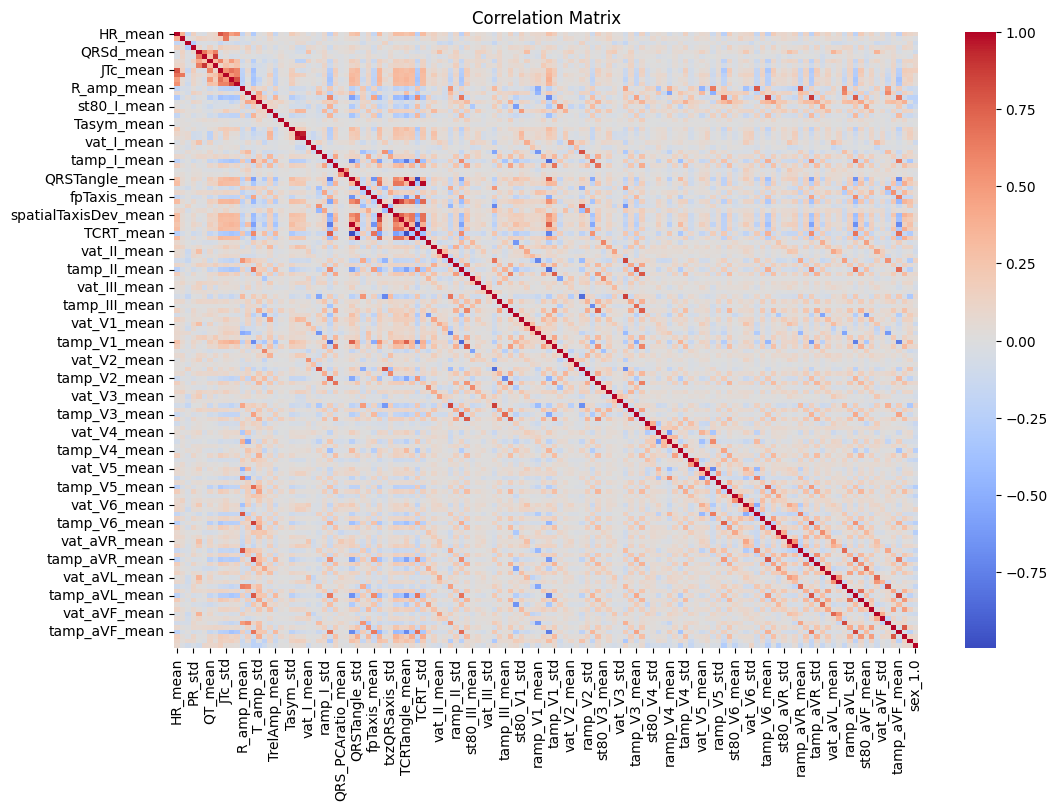

Dropped features: {'TCRTangle_std', 'spatialTaxisDev_mean', 'TCRT_std', 'TMD_std', 'TCRT_mean', 'TCRTangle_mean'}


In [6]:
corr_matrix = X_train.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

threshold = 0.9
to_drop = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            to_drop.add(corr_matrix.columns[i])

X_train = X_train.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)
print('Dropped features:', to_drop)

from scipy.stats import pointbiserialr


### 6. Outlier Removal

In [7]:
z_scores = np.abs(stats.zscore(X_train))
filtered = (z_scores < 3).all(axis=1)
X_train = X_train[filtered]
y_train = y_train.loc[filtered]
print('Shape after outlier removal:', X_train.shape)

Shape after outlier removal: (4770, 130)


### 7. Balancing with SMOTE + Tomek

In [8]:
smote_tomek = SMOTETomek(random_state=42)
X_train_res, y_train_res = smote_tomek.fit_resample(X_train, y_train)
print('Class balance after SMOTE:', y_train_res.value_counts())

Class balance after SMOTE: condition
Normal                   3655
Myocardial Infarction    3655
CAD                      3655
Name: count, dtype: int64


### 8. Save Preprocessed Datasets

In [9]:
train_final = pd.DataFrame(X_train_res, columns=X_train.columns)
train_final['condition'] = y_train_res.values

test_final = X_test.copy()
test_final['condition'] = y_test.values

train_final.to_csv('ECG_train_preprocessed.csv', index=False)
test_final.to_csv('ECG_test_preprocessed.csv', index=False)
print('✅ Preprocessed train/test datasets saved.')

C:\Users\Hajel\AppData\Local\Temp\ipykernel_23840\611706242.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_final['condition'] = y_train_res.values


✅ Preprocessed train/test datasets saved.
